<a href="https://colab.research.google.com/github/LucioJuniorMachado/Trabalho_Redes_Neurais/blob/main/2_modelos_multimodais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Zero-shot object detection**

# Instalando as bibliotecas necessárias

In [14]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
!pip install Pillow
!pip install matplotlib
!pip install opencv-python
import cv2
import skimage
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display # Import display if not already imported in the first cell

In [16]:
from transformers.utils import send_example_telemetry

send_example_telemetry("IDEA-Research/grounding-dino-base", framework="pytorch")

# Carregando modelo pré-treinado e processador

In [17]:
from transformers import AutoProcessor, OwlViTForObjectDetection, OwlViTProcessor

# Increase the timeout for downloading the model files
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32") #, request_timeout=60.0)

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

In [19]:
from transformers import AutoProcessor, OwlViTForObjectDetection, OwlViTProcessor

# Increase the timeout for downloading the model files
# Explicitly specify the revision to try and resolve potential issues with the latest version
# Remove request_timeout and revision as they are not parameters for the model's __init__
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# The processor also doesn't need these arguments for its __init__
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

# Fazendo o download da imagem

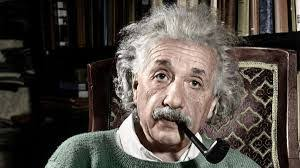

In [20]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRVnXoO798Cv_gfLX_zxvO3Lm4_CaK32J51NQ&s"
image = Image.open(requests.get(url, stream=True).raw)

image_array = skimage.io.imread(url)
# Create a PIL Image object from the NumPy array
im = Image.fromarray(image_array)
# Use display to show the image in the notebook
display(im)

# Text queries to search the image for
text_queries = ["human face", "pipe", "chair", "books"]

In [21]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [22]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")


input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


In [23]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 512])
pooler_output: shape of torch.Size([4, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


# Detectando a imagem, desenhando sua predição

In [24]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

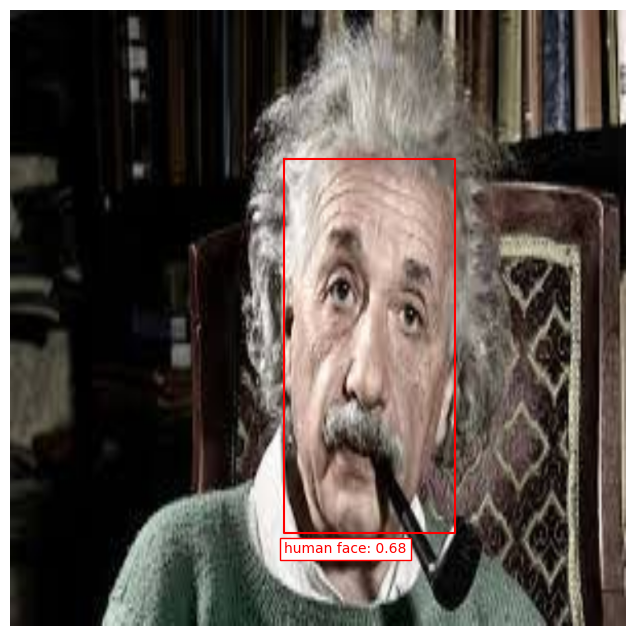

In [25]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

plot_predictions(input_image, text_queries, scores, boxes, labels)

#**Zero-shot classification para classificação de imagem em diferentes categorias**

# Instalando as bibliotecas

In [26]:
! pip install -q "transformers[torch]" pillow
import cv2
import skimage
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display # Import display if not already imported in the first cell

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.6 MB/s eta 0:00:00


# Instanciando a pipeline



In [35]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification, pipeline # Import the pipeline function

# Define the checkpoint name for the zero-shot image classification model
checkpoint = "openai/clip-vit-base-patch32" # Replace with the desired model checkpoint

# Create the zero-shot image classification pipeline
detector = pipeline("zero-shot-image-classification", model=checkpoint) # Assign the pipeline to the variable 'detector'

model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

Device set to use cuda:0


# Importando mais bibliotecas e carregando a imagem

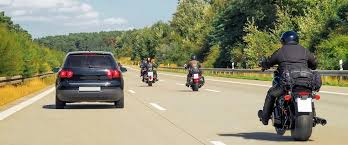

In [36]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR2pzAJyx7WdXZpkBpz389qQCAFcX45_G1ccg&s"
image = Image.open(requests.get(url, stream=True).raw)

image_array = skimage.io.imread(url)
# Create a PIL Image object from the NumPy array
im = Image.fromarray(image_array)
# Use display to show the image in the notebook
display(im)

# Fazendo as predições por classes

In [38]:
predictions = detector(image, candidate_labels=["human being", "road", "car", "motocycle"])
predictions

[{'score': 0.901451051235199, 'label': 'motocycle'},
 {'score': 0.09049287438392639, 'label': 'road'},
 {'score': 0.007408765144646168, 'label': 'car'},
 {'score': 0.0006472842651419342, 'label': 'human being'}]